# Matrix Factorization From Scratch

In [1]:
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import os
from subprocess import call

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"] = 12

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,sklearn

Author: Ethen

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.28.0

numpy     : 1.21.3
pandas    : 1.3.4
matplotlib: 3.5.1
sklearn   : 1.0.1



## Load Data

In [2]:
data_dir = "../data/"
file_dir = os.path.join(data_dir, "ml-100k")
file_path = os.path.join(data_dir, file_dir, "u.data")

if not os.path.isdir(file_dir):
    call(["curl", "-O", "http://files.grouplens.org/datasets/movielens/ml-100k.zip"])
    call(["unzip", "ml-100k.zip", "-d", "../data/"])
    call(["rm", "ml-100k.zip"])

names = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(file_path, sep="\t", names=names)

print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
n_users = df["user_id"].unique().shape[0]
n_items = df["item_id"].unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples(index=False):
    ratings[row.user_id - 1, row.item_id - 1] = row.rating

# Compute the non-zero elements in the rating matrix
matrix_size = np.prod(ratings.shape)
iteraction = np.flatnonzero(ratings).shape[0]
sparsity = 100 * (iteraction / matrix_size)

print("dimension: ", ratings.shape)
print("sparsity: {:.1f}%".format(sparsity))
ratings

dimension:  (943, 1682)
sparsity: 6.3%


array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

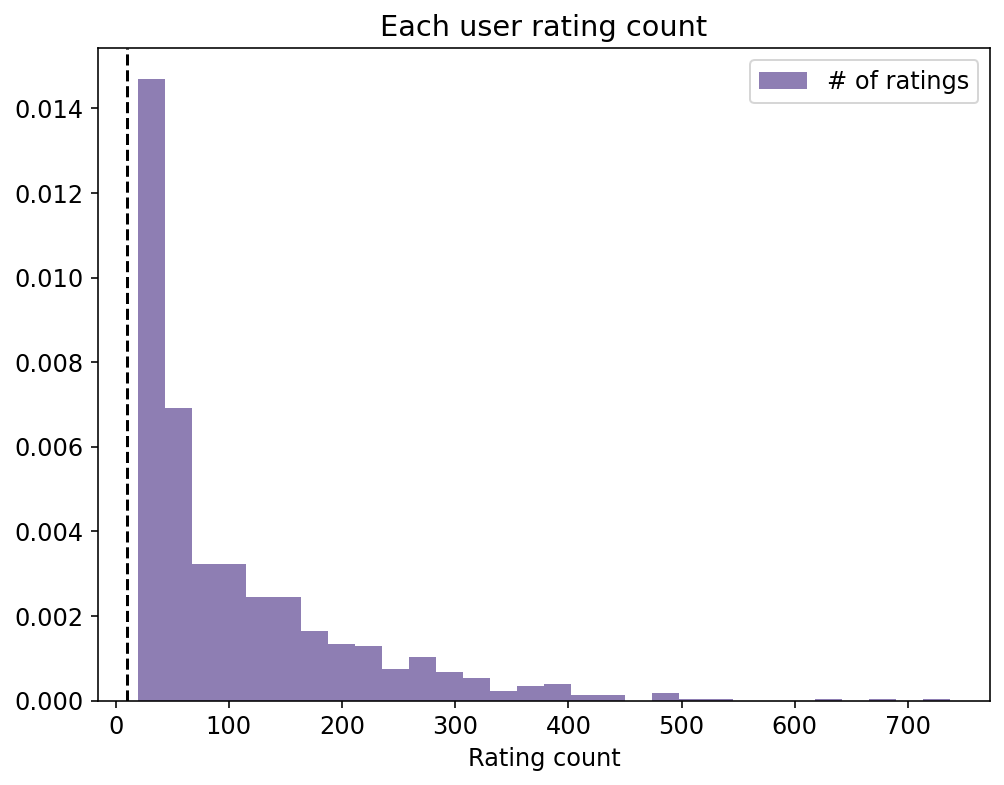

In [4]:
plt.title("Each user rating count")
plt.xlabel("Rating count")
plt.hist(
    np.sum(ratings != 0, axis=1),
    histtype="stepfilled",
    bins=30,
    alpha=0.85,
    label="# of ratings",
    color="#7A68A6",
    density=True,
)
plt.axvline(x=10, color="black", linestyle="--")
plt.legend(loc="upper right")
plt.show()

In [5]:
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 10 ratings from each user
    and assign them to the test set.
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size=10, replace=False
        )

        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]

    # Assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test


train, test = create_train_test(ratings)
del ratings
train

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

## Matrix Factorization

In [6]:
class ExplicitMF:
    """
    Train a matrix factorization model using Alternating Least Squares
    to predict empty entries in a matrix

    Parameters
    ----------
    n_iters : int
        number of iteractions to train the algorithm

    n_factors : int
        number of latent factors to use in matrix
        factorization model, same machine-learning libraries
        denote this as rank

    reg : float
        regularization term for item/user latent factors,
        since lambda is a keyword in python we use reg instead
    """

    def __init__(self, n_iters, n_factors, reg):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors

    def fit(self, train, test):
        """
        Pass in training and testing at the same time to record
        model convergence, assuming both dataset is in the form
        of User x Item matrix with cells as ratings
        """
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))

        # Record the training and testing mse for every iteration
        # to show convergence later (usualy, not worth it for production)
        self.test_mse_record = []
        self.train_mse_record = []
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(
                train, self.user_factors, self.item_factors
            )
            self.item_factors = self._als_step(
                train.T, self.item_factors, self.user_factors
            )

            predictions = self.predict()

            test_mse = self.compute_mse(test, predictions)
            train_mse = self.compute_mse(train, predictions)
            self.test_mse_record.append(test_mse)
            self.train_mse_record.append(train_mse)

        return self

    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        """
        When updating the user matrix,
        the item matrix is the fixed vector and vice versa
        """
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs

    def predict(self):
        """
        Predict ratings for every user and item
        """
        pred = self.user_factors.dot(self.item_factors.T)
        return pred

    @staticmethod
    def compute_mse(y_true, y_pred):
        """
        Ignore zero terms prior to comparing the mse
        """
        mask = np.nonzero(y_true)
        mse = mean_squared_error(y_true[mask], y_pred[mask])
        return mse

In [7]:
als = ExplicitMF(n_iters=100, n_factors=40, reg=0.01)
als.fit(train, test)

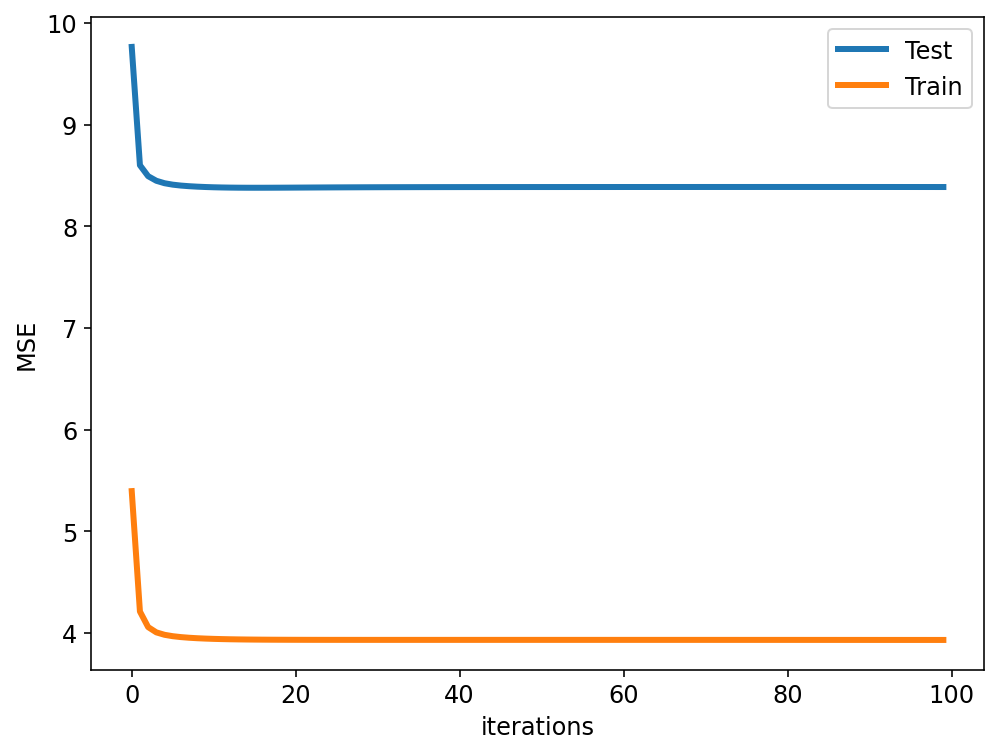

In [8]:
def plot_learning_curve(model):
    """Visualize the training/testing loss"""
    linewidth = 3
    plt.plot(model.test_mse_record, label="Test", linewidth=linewidth)
    plt.plot(model.train_mse_record, label="Train", linewidth=linewidth)
    plt.xlabel("iterations")
    plt.ylabel("MSE")
    plt.legend(loc="best")
    plt.show()


plot_learning_curve(als)

## Glossary

- ALS
    - Alternating Least Square

## Reference
- https://nbviewer.org/github/ethen8181/machine-learning/blob/master/recsys/1_ALSWR.ipynb